In [3]:
from dt_apriltags import Detector
import numpy as np
import os
import cv2
from cv2 import imshow
import matplotlib.pyplot as plt
import copy
import torch

from torch import nn
import copy
import math

from PIL import Image
from matplotlib import image

import pickle
import time


import controller_track_taskspace as contr
#from pybullet_helpers import *
from trajectory_generator import *
from extract_density import *

import FrEIA.framework as Ff
import FrEIA.modules as Fm
import torch.nn as nn

from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

at_detector = Detector(families='tag25h9',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

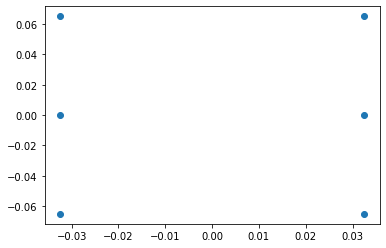

In [4]:
dist_g=0.065
width_s=2.
height_s=3.

width_np=np.arange(0,width_s)
height_np=np.arange(0,height_s)

w, h = np.meshgrid(width_np, height_np, indexing='ij')
grid=np.concatenate([w[:,:,None],h[:,:,None]],2).reshape((-1,2))

t_grid=copy.copy(grid)
t_grid[:,0]=((grid[:,0]+0.5)-0.5*width_s)*dist_g
t_grid[:,1]=((grid[:,1]+0.5)-0.5*height_s)*dist_g

plt.scatter(t_grid[:,0],t_grid[:,1])
t_grid_3d=np.concatenate([t_grid,np.zeros((len(t_grid),1))],axis=1)

In [5]:
img = cv2.imread('imgs/img1.JPG', cv2.IMREAD_GRAYSCALE)
focal_length = 1802
size=img.shape
center = (size[1]/2, size[0]/2)
mtx=np.array([[focal_length, 0, center[0]],
             [0, focal_length, center[1]],
             [0, 0, 1]], dtype = "double")
distortion_coeffs = np.array([])
camera_params_c=[focal_length,focal_length,1504,1000]

def get_rot_t(file_str,t_grid_3d):
    img = cv2.imread(file_str, cv2.IMREAD_GRAYSCALE)
    tags = at_detector.detect(img, estimate_tag_pose=True, 
                              camera_params=camera_params_c, 
                              tag_size=0.05)
    tags_cent_list=[]
    print(len(tags))
    for i in range(len(tags)):
        tags_cent_list.append(tags[i].center)
    tags_cent_np=np.vstack(tags_cent_list)
    success, vector_rotation, vector_translation = cv2.solvePnP(t_grid_3d,
                                                                tags_cent_np, 
                                                                mtx, distortion_coeffs)
    R,_=cv2.Rodrigues(vector_rotation)
    return (R,vector_translation,vector_rotation)

In [6]:
R1,T1,V1=get_rot_t('imgs/img0.JPG',t_grid_3d)
R2,T2,V2=get_rot_t('imgs/img1.JPG',t_grid_3d)

6
6


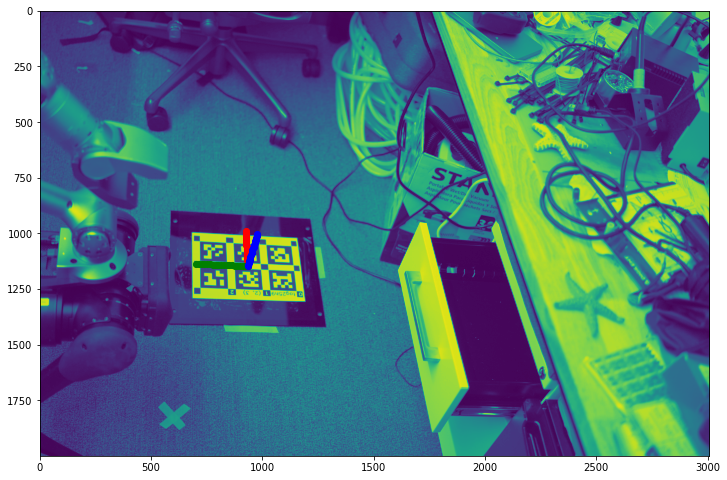

In [7]:
x_points=[]
y_points=[]
z_points=[]
for num in range(0,20):
    nose_end_point2D, jacobian = cv2.projectPoints(np.array([(0.005*num, 0.0, 0.0)]), 
                                                   V1, T1, 
                                                   mtx, distortion_coeffs)
    point_x = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
    x_points.append(point_x)
    nose_end_point2D, jacobian = cv2.projectPoints(np.array([(0.0, 0.005*num, 0.0)]), 
                                                   V1, T1,
                                                   mtx, distortion_coeffs)
    point_y = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
    y_points.append(point_y)
    nose_end_point2D, jacobian = cv2.projectPoints(np.array([(0.0, 0.0, 0.005*num)]), 
                                                   V1, T1,
                                                   mtx, distortion_coeffs)
    point_z = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
    z_points.append(point_z)
x_np=np.array(x_points)
y_np=np.array(y_points)
z_np=np.array(z_points)
img = cv2.imread('imgs/img0.JPG', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.scatter(x_np[:,0],x_np[:,1],c='r',marker='.',s=150)
plt.scatter(y_np[:,0],y_np[:,1],c='g',marker='.',s=150)
plt.scatter(z_np[:,0],z_np[:,1],c='b',marker='.',s=150)

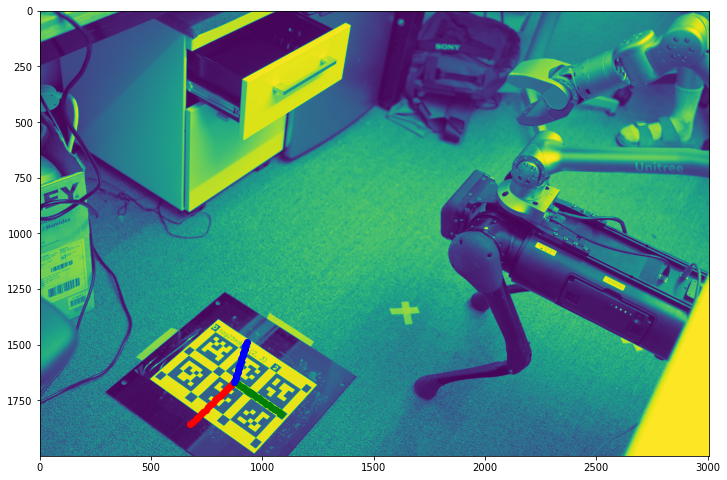

In [8]:
x_points=[]
y_points=[]
z_points=[]
for num in range(0,20):
    nose_end_point2D, jacobian = cv2.projectPoints(np.array([(0.005*num, 0.0, 0.0)]), 
                                                   V2, T2, 
                                                   mtx, distortion_coeffs)
    point_x = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
    x_points.append(point_x)
    nose_end_point2D, jacobian = cv2.projectPoints(np.array([(0.0, 0.005*num, 0.0)]), 
                                                   V2, T2,
                                                   mtx, distortion_coeffs)
    point_y = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
    y_points.append(point_y)
    nose_end_point2D, jacobian = cv2.projectPoints(np.array([(0.0, 0.0, 0.005*num)]), 
                                                   V2, T2,
                                                   mtx, distortion_coeffs)
    point_z = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
    z_points.append(point_z)
x_np=np.array(x_points)
y_np=np.array(y_points)
z_np=np.array(z_points)
img = cv2.imread('imgs/img1.JPG', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.scatter(x_np[:,0],x_np[:,1],c='r',marker='.',s=150)
plt.scatter(y_np[:,0],y_np[:,1],c='g',marker='.',s=150)
plt.scatter(z_np[:,0],z_np[:,1],c='b',marker='.',s=150)